## Prepare the workspace

In [2]:
# Check torch version and CUDA status if GPU is enabled.

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import time

print(torch.__version__)
print(torch.cuda.is_available()) 
torch.cuda.empty_cache()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


2.5.1
False


# Developing the AI application

In this project, we train an image classifier to recognize different species of flowers. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on dataset
* Use the trained classifier to predict image content

## Load the data

Here we use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). 

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, we apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. we also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
# Define your transforms for the training, validation, and testing sets
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225])])

# Load the Flowers102 dataset with torchvision
train_dataset = datasets.Flowers102(root='path_to_data', split='train', transform=train_transform, download=True)
valid_dataset = datasets.Flowers102(root='path_to_data', split='val', transform=test_transform, download=True)
test_dataset = datasets.Flowers102(root='path_to_data', split='test', transform=test_transform, download=True)

# Using the datasets, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)



### Label mapping

we'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [3]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
len(cat_to_name)


102

In [73]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. Then we build and train a new feed-forward classifier using those features.


* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html). We'll try **VGG16**.
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [4]:
# Fetch the pre-trained model
model = models.vgg16(pretrained=True)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
class Classifier_Layer(nn.Module):
    """
    Defines a simple custom classifier layer for the network.
    
    INPUT:
    ---------
    input_size: int, size of the input layer (e.g., 25088 for VGG)
    output_size: int, size of the output layer (e.g., number of classes)
    hidden_layers: list of ints, sizes of hidden layers (e.g., [1024, 256])
    drop_p: float, dropout probability (default 0.2)
    """
    
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.2):
        super().__init__()
        
        # Initialize the layers
        self.hidden_layers = nn.ModuleList()
        
        # Add the first hidden layer (input -> first hidden layer)
        self.hidden_layers.append(nn.Linear(input_size, hidden_layers[0]))
        
        # Add the remaining hidden layers
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
        
        # Add the output layer (last hidden layer -> output)
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        """ Forward pass through the network, returns the output logits """
        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Pass through each hidden layer
        for layer in self.hidden_layers:
            x = F.relu(layer(x))  # Apply activation
            x = self.dropout(x)   # Apply dropout after activation

        # Pass through the output layer
        x = self.output(x)

        return F.log_softmax(x, dim=1)


In [14]:
model.classifier = Classifier_Layer(25088,102, [1024,256])

In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
for param in model.features.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():  
    param.requires_grad = True

In [115]:
best_accuracy = 0  # Initialize to track the best accuracy
best_model_path = "best_model_classifier.pth"  # Path to save the best model

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 4
steps = 0

train_losses, valid_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for e in range(epochs):
    running_loss = 0
    print(f"Starting epoch {e+1}/{epochs}")

    for images, labels in trainloader:
        steps += 1

        # Move data to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Perform validation every 4 steps
        if steps % 4 == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()  # Set the model to evaluation mode

            with torch.no_grad():
                for val_images, val_labels in validloader:
                    val_images, val_labels = val_images.to(device), val_labels.to(device)
                    
                    # Forward pass
                    log_ps = model(val_images)
                    batch_loss = criterion(log_ps, val_labels)
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == val_labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Log stats
            train_loss_avg = running_loss / len(trainloader)
            valid_loss_avg = valid_loss / len(validloader)
            valid_accuracy = accuracy / len(validloader)
            
            train_losses.append(train_loss_avg)
            valid_losses.append(valid_loss_avg)

            print(f"Step {steps}.. "
                  f"Train Loss: {train_loss_avg:.3f}.. "
                  f"Validation Loss: {valid_loss_avg:.3f}.. "
                  f"Validation Accuracy: {valid_accuracy*100:.2f}%")

            # Save the best model
            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                torch.save(model.classifier.state_dict(), best_model_path)
                print(f"Saved best model with accuracy: {best_accuracy * 100:.2f}%")
            else:
                print("Model shows no improvement. Model not saved.")

        model.train()  # Set the model back to training mode

    # Print summary after the epoch
    print(f"Epoch {e+1}/{epochs} completed.")


Starting epoch 1/4
Step 4.. Train Loss: 0.048.. Validation Loss: 1.050.. Validation Accuracy: 72.82%
Saved best model with accuracy: 72.82%
Step 8.. Train Loss: 0.129.. Validation Loss: 0.836.. Validation Accuracy: 77.67%
Saved best model with accuracy: 77.67%
Step 12.. Train Loss: 0.191.. Validation Loss: 0.848.. Validation Accuracy: 75.71%
Model shows no improvement. Model not saved.
Step 16.. Train Loss: 0.248.. Validation Loss: 0.770.. Validation Accuracy: 77.34%
Model shows no improvement. Model not saved.
Step 20.. Train Loss: 0.300.. Validation Loss: 0.734.. Validation Accuracy: 81.18%
Saved best model with accuracy: 81.18%
Step 24.. Train Loss: 0.366.. Validation Loss: 0.648.. Validation Accuracy: 82.65%
Saved best model with accuracy: 82.65%
Step 28.. Train Loss: 0.417.. Validation Loss: 0.630.. Validation Accuracy: 82.12%
Model shows no improvement. Model not saved.
Step 32.. Train Loss: 0.470.. Validation Loss: 0.577.. Validation Accuracy: 83.65%
Saved best model with accura

In [116]:
len(trainloader)

52

## Testing Our Network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. 

In [121]:
# Load the best model state
model.classifier.load_state_dict(torch.load(best_model_path))
print("Best model state loaded.")

# Set the model to evaluation mode
model.eval()

# Move the model to GPU if available
model = model.to(device)

# Initialize lists to store predictions and corresponding labels
all_predictions = []
all_labels = []

# Initialize accuracy variables
correct = 0
total = 0

# Disable gradient calculations for inference
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader, 1):  # Start batch count at 1
        images, labels = images.to(device), labels.to(device)
        
        print(f"testing batch {batch}")
        
        # Forward pass to get predictions
        log_ps = model(images)
        ps = torch.exp(log_ps)  # Convert log probabilities to probabilities

        # Get the top predicted class
        top_p, top_class = ps.topk(1, dim=1)

        # Compare predictions to true labels
        equals = top_class.view(-1) == labels
        correct += torch.sum(equals).item()
        total += labels.size(0)

        # Store predictions and true labels
        all_predictions.extend(top_class.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Convert predictions and labels to arrays for further analysis
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Print a few predictions for sanity check
    print(f"Predictions: {all_predictions[:10]}")
    print(f"True Labels: {all_labels[:10]}")

    # Calculate overall accuracy
    test_accuracy = correct / total * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")


Best model state loaded.
testing batch 1
testing batch 2
testing batch 3
testing batch 4
testing batch 5
testing batch 6
testing batch 7
testing batch 8
testing batch 9
testing batch 10
testing batch 11
testing batch 12
testing batch 13
testing batch 14
testing batch 15
testing batch 16
testing batch 17
testing batch 18
testing batch 19
testing batch 20
testing batch 21
testing batch 22
testing batch 23
testing batch 24
testing batch 25
testing batch 26
Predictions: [[ 0]
 [ 0]
 [ 0]
 [99]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 2]
 [38]]
True Labels: [0 0 0 0 0 1 1 1 2 2]
Test Accuracy: 88.16%


## Save the checkpoint

Now that the network is trained, we'll save the model so it can be loaded later for making predictions. We'll also save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. we can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

In [124]:
# Save the checkpoint with fixed hidden layers extraction
model.to('cpu')  # Ensure the model is on CPU for saving

# Create the checkpoint
checkpoint = {
    'input_size': 25088,  # Input size of the model (e.g., for VGG16)
    'output_size': 102,   # Number of output classes
    'hidden_layers': [layer.out_features for layer in model.classifier.hidden_layers],
    'drop_p': 0.2,  # Dropout probability (if applicable)
    'state_dict': model.state_dict(),  # Model's state_dict
    'class_to_idx': model.class_to_idx  # Class-to-index mapping
}

filepath = 'checkpoint.pth'

# Save the model
torch.save(checkpoint, filepath)
print(f"Model checkpoint saved to {filepath}")


Model checkpoint saved to checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [17]:
#The function below loads the checkpoint and recreates the model
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = Classifier_Layer(checkpoint['input_size'],checkpoint['output_size'], checkpoint['hidden_layers'])
    
    model.load_state_dict(checkpoint['state_dict']) 
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model


In [18]:
saved_model = load_checkpoint('checkpoint.pth')

In [19]:
saved_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. We'll write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 

First we'll handle processing the input image such that it can be used in your network. 

## Image Preprocessing

We'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

In [43]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    

    # Open the image
    pil_image = Image.open(image)

    # Resize so the shortest side is 256 pixels while maintaining aspect ratio
    pil_image = pil_image.resize((256, int(pil_image.height * 256 / pil_image.width)) 
                                  if pil_image.width < pil_image.height 
                                  else (int(pil_image.width * 256 / pil_image.height), 256))

    # Center crop the image to 224x224
    width, height = pil_image.size
    new_width, new_height = 224, 224
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    pil_image = pil_image.crop((left, top, right, bottom))

    # Convert the image to a NumPy array
    np_image = np.array(pil_image) / 255.0  # Scale pixel values to [0, 1]

    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions to CxHxW
    np_image = np_image.transpose((2, 0, 1))

    
    return np_image


In [5]:
def imshow(image, ax=None, title=None):
    """Imshow for a NumPy array."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension,
    # but matplotlib assumes it is the last dimension.
    if isinstance(image, torch.Tensor):  # Handle PyTorch tensors
        image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    
    # Undo preprocessing (if applicable)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # De-normalize
    image = np.clip(image, 0, 1)  # Clip to valid range [0, 1]
    
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')
    
    return ax


## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll calculate the class probabilities then find the $K$ largest values.

In [85]:
def plot_ps(top_p, top_class, top_k, idx_to_class, cat_to_name):
    # Convert tensors to NumPy arrays for plotting
    top_p = top_p.squeeze().cpu().numpy()
    top_class = top_class.squeeze().cpu().numpy()
    
    # Convert numerical indices to folder labels using idx_to_class
    top_labels_idx = [idx_to_class[idx] for idx in top_class]

    # Map folder labels to flower names using cat_to_name
    top_labels_names = [cat_to_name[str(idx)] for idx in top_labels_idx]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.bar(range(top_k), top_p, tick_label=top_labels_names, color='skyblue')
    plt.title(f"Top-{top_k} Predictions")
    plt.xlabel("Class Label")
    plt.ylabel("Probability")
    plt.xticks(ticks=range(top_k), labels=top_labels_names, rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Display the plot
    plt.show()


In [94]:
def predict(image_path, model_checkpoint, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    
    # Load the model from checkpoint
    model = load_checkpoint(model_checkpoint)
    class_to_idx = model.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping

    # Process the image
    image = process_image(image_path)  # Returns a NumPy array (C, H, W)
    image_tensor = torch.from_numpy(image).float().unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        model.eval()
        logits = model(image_tensor)  # Forward pass
        ps = torch.exp(logits)  # Convert logits to probabilities
        top_p, top_class = ps.topk(top_k, dim=1)  # Get top-k predictions
    
    
    # Convert top_class to corresponding folder labels
    top_classes = top_class.squeeze().cpu().numpy()  # Get top class indices
    folder_labels = [idx_to_class[i] for i in top_classes]  # Map indices to folder labels

    # Map folder labels to flower names using cat_to_name
    flower_names = [cat_to_name[label] for label in folder_labels]
    
    # Prepare results
    results = list(zip(flower_names, top_p.squeeze().cpu().numpy()))

    # Display predictions
    print("Predictions:")
    for name, prob in results:
        print(f"{name}: {prob:.3f}")
    
    # Prepare image for display
    image_to_display = image_tensor.squeeze(0).permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    img_plot = imshow(image_to_display, ax=None, title=None)
    
    

        # Plot predictions, now passing idx_to_class to plot_ps
    p_plot = plot_ps(top_p, top_class, top_k, idx_to_class, cat_to_name)
    
    return results, img_plot, p_plot


## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. 

In [95]:
# TODO: Display an image along with the top 5 classes
test_img_path = "flowers/test/14/image_06052.jpg"

In [96]:
image = process_image(test_img_path)
image.shape

(3, 224, 224)

Predictions:
spear thistle: 0.985
artichoke: 0.015
king protea: 0.000
purple coneflower: 0.000
globe thistle: 0.000


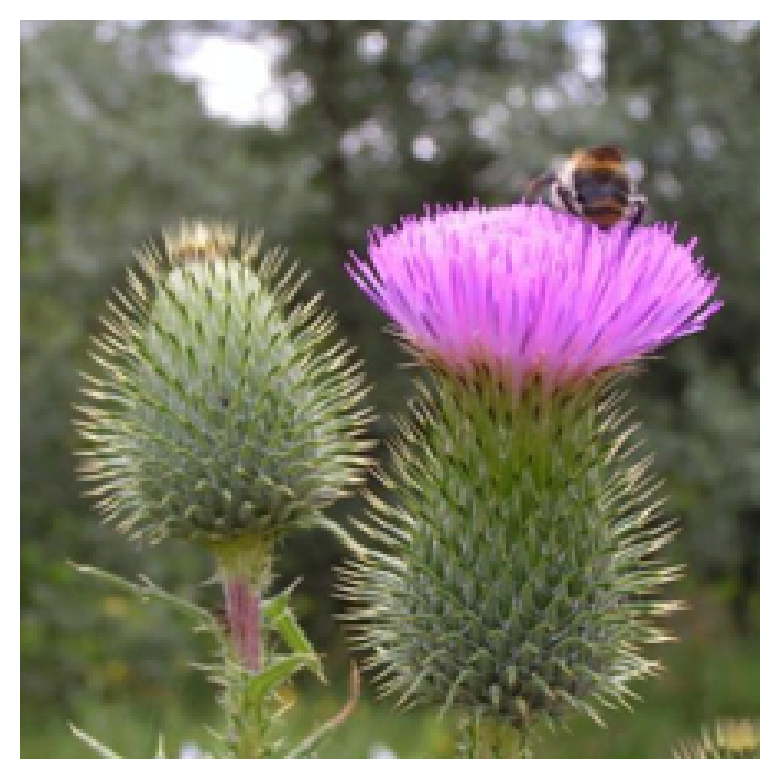

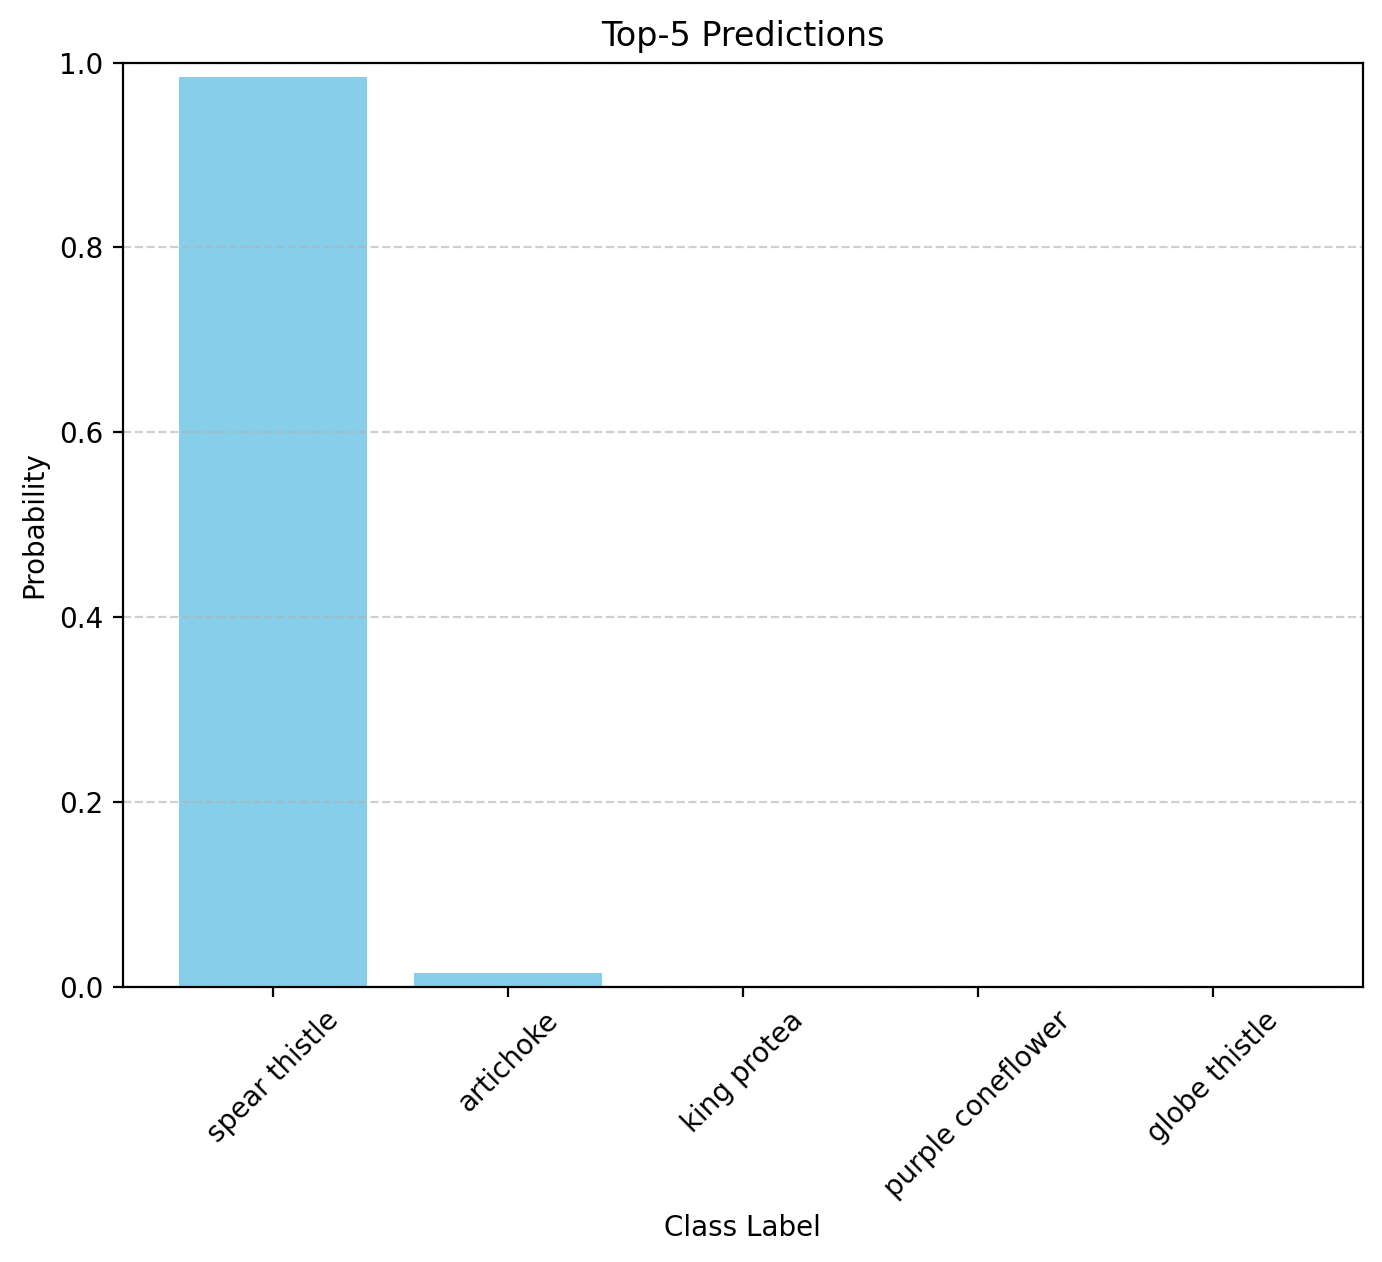

([('spear thistle', 0.9847505),
  ('artichoke', 0.015020878),
  ('king protea', 0.0002278968),
  ('purple coneflower', 3.812222e-07),
  ('globe thistle', 2.3733148e-07)],
 <Axes: >,
 None)

In [97]:
predict(test_img_path, 'checkpoint.pth', top_k=5)

In [98]:
# TODO: Display an image along with the top 5 classes
test_img_2 = "flowers/test/101/image_07952.jpg"

In [99]:
image = process_image(test_img_2)
image.shape

(3, 224, 224)

Predictions:
trumpet creeper: 0.997
rose: 0.001
anthurium: 0.001
snapdragon: 0.000
petunia: 0.000


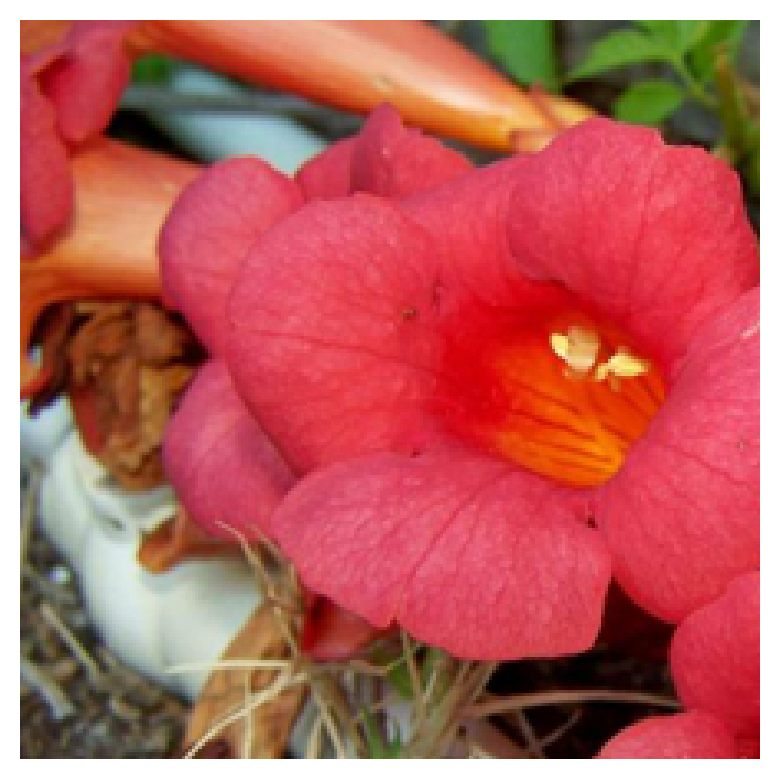

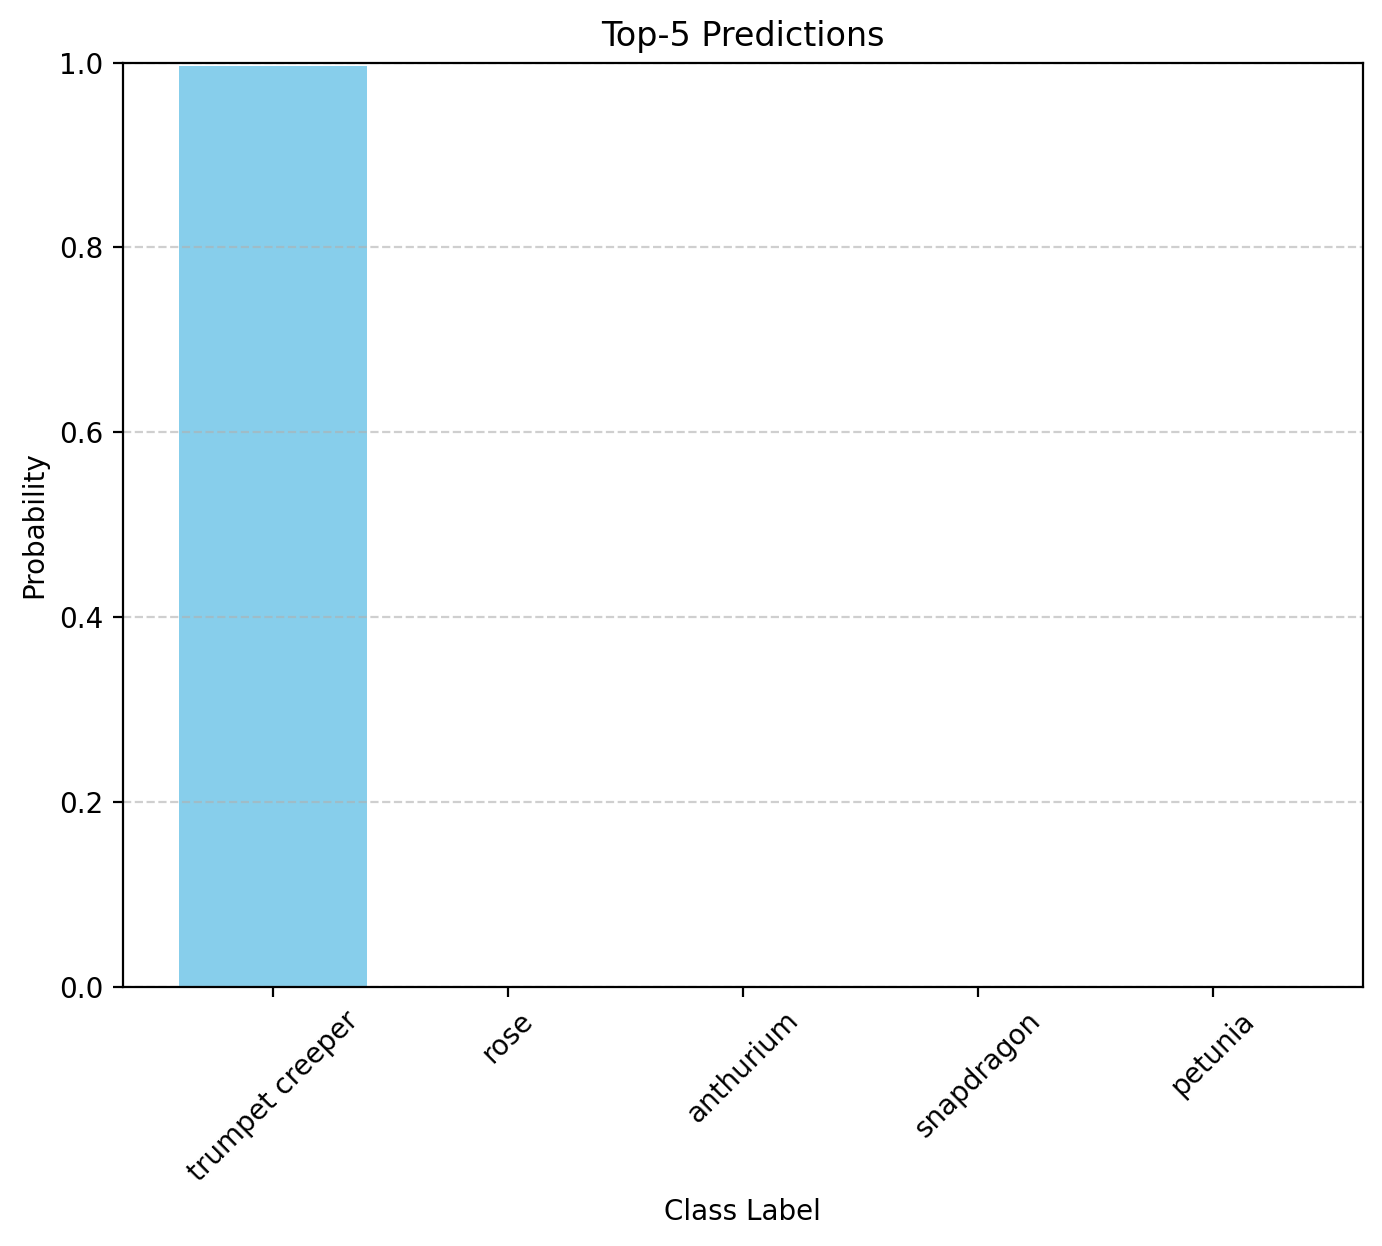

([('trumpet creeper', 0.9965669),
  ('rose', 0.0010815769),
  ('anthurium', 0.0005686726),
  ('snapdragon', 0.00034240313),
  ('petunia', 0.00032802808)],
 <Axes: >,
 None)

In [100]:
predict(test_img_2, 'checkpoint.pth', top_k=5)

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
!rm checkpoint.pth